### Programa para determinar los parámetros de la línea incluyendo la conductividad del terreno.

 Basado en el libro Power System Transients: Parameter Determination,
 Martinez Velasco.
 Programado por : Ernesto Pérez
   Marzo 10 de 2014


 Se ingresan los parámetros geométricos de la líena
 se determinan las distancias
 Se calculan los parámetros


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.collections as mcollections
import pandas as pd
from cond_clases  import *




### Definición de los objetos de conductores

In [29]:
mu_0=4* np.pi*1e-7
eps_0=8.85e-12

In [30]:
sigma_g=0.01
mu_gr=1
eps_gr=10
freq=60

cond_p=cable('flicker', r=0.012, Rdc=0.102298851, Rac=0.125287356, Tac=75, Imax=659)#
cond_p2=cable('parakeet', r=0.010, Rdc=0.088218391, Rac=0.125287356, Tac=75, Imax=659)
cond_n=cable('OPGW AC47', r=0.0725, Rdc=0.3, Rac=0.3, Tac=75, Imax=400)
cond_1=conductor(cond_p,'a',0,20)
cond_2=conductor(cond_p,'b',4,20)
cond_3=conductor(cond_p,'c',8,20)
cond_1n=conductor(cond_n,'n',0,24)
conductors=[cond_1,cond_2,cond_3,cond_1n]
#print(conductors)
T1=Tower('115kV',conductors)



In [31]:
(cond_p.r-cond_p2.r)/cond_p.r*100


16.666666666666664

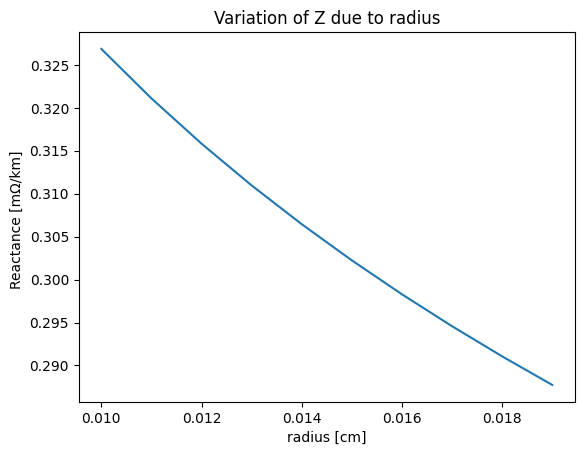

In [47]:
h=[20,22,24,26,28,30]
sep=[2,3,4,5]
rcon = [cond_p2.r * (1 + 0.1 * i) for i in range(10)]  # Use list comprehension to populate rcon
z1_variation = []
for r in rcon:
    for j in range(T1.n_cond):
        T1.phases[j].c.r = r  # Assign the radius directly
    Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)
fig, ax = plt.subplots()
line, = ax.plot(rcon, z1_variation)
ax.set_title("Variation of Z due to radius")
ax.set_xlabel("radius [cm]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()

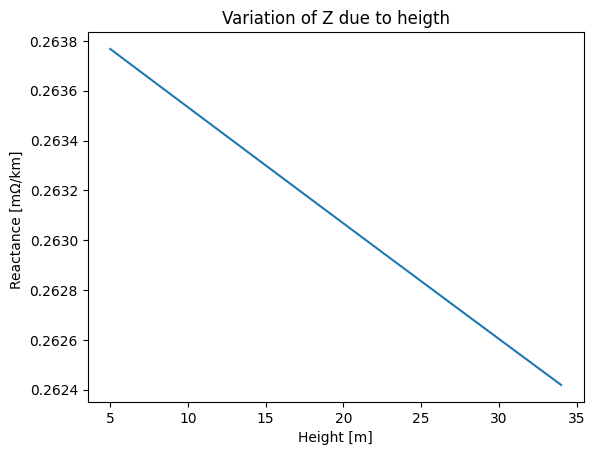

In [46]:
heigths=[5+i for i in range(30)]

z1_variation = []
for h in heigths:
    for j in range(T1.n_cond):
        if j < T1.n_cond-1:
            T1.phases[j].pos_y = h  # Assign the radius directly
        else:
            T1.phases[j].pos_y = h+4 #height neutral conductor
    Zall = calc_param(T1, freq, .01, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)
fig, ax = plt.subplots()
line, = ax.plot(heigths, z1_variation)
ax.set_title("Variation of Z due to heigth")
ax.set_xlabel("Height [m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()

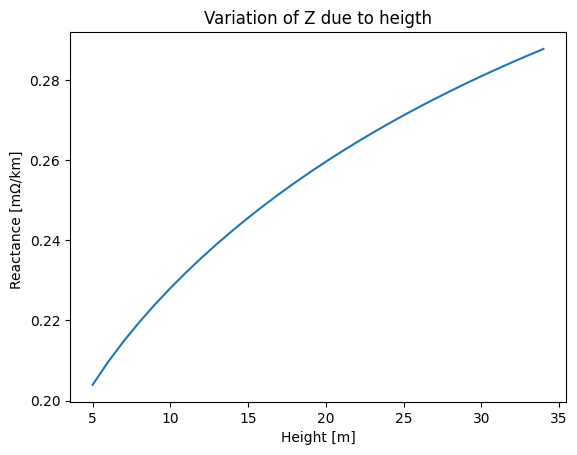

In [45]:
sep=[1+i*.2 for i in range(30)]

z1_variation = []
for s in sep:
    for j in range(T1.n_cond):
        if j>0 and j < T1.n_cond-1:
            T1.phases[j].pos_x = T1.phases[j-1].pos_x+s  # Assign the radius directly
        elif j>=T1.n_cond-1:
            T1.phases[j].pos_x = T1.phases[j-1].pos_x#height neutral conductor
    Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)
fig, ax = plt.subplots()
line, = ax.plot(heigths, z1_variation)
ax.set_title("Variation of Z due to heigth")
ax.set_xlabel("Height [m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()

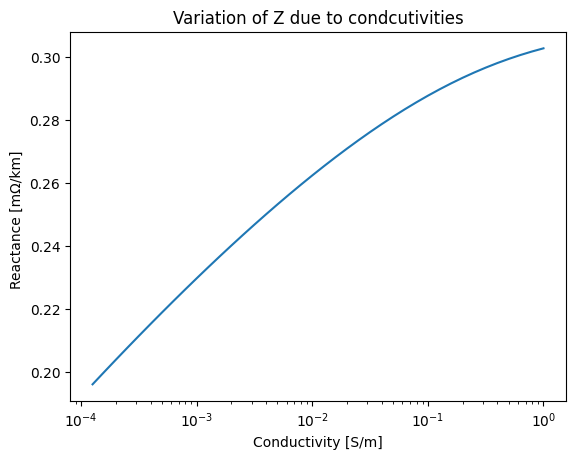

[1.0, 0.7943282347242815, 0.6309573444801932, 0.5011872336272724, 0.39810717055349726, 0.31622776601683794, 0.251188643150958, 0.199526231496888, 0.15848931924611134, 0.12589254117941673, 0.1, 0.07943282347242814, 0.06309573444801933, 0.05011872336272723, 0.039810717055349734, 0.0316227766016838, 0.025118864315095798, 0.0199526231496888, 0.015848931924611134, 0.012589254117941677, 0.010000000000000002, 0.007943282347242814, 0.00630957344480193, 0.0050118723362727255, 0.003981071705534974, 0.00316227766016838, 0.00251188643150958, 0.001995262314968879, 0.0015848931924611143, 0.0012589254117941677, 0.0010000000000000002, 0.0007943282347242814, 0.0006309573444801931, 0.0005011872336272725, 0.0003981071705534974, 0.000316227766016838, 0.000251188643150958, 0.00019952623149688793, 0.00015848931924611145, 0.00012589254117941677]


In [59]:

z1_variation = []
conductivities=[.1**(i/10) for i in range(40)]
for sigma_g in conductivities:
    Zall = calc_param(T1, freq, sigma_g, mu_gr, eps_gr)
    z1_variation.append(np.imag(Zall.z1)*1e3)

fig, ax = plt.subplots()
line, = ax.plot(conductivities, z1_variation)
ax.set_xscale('log')
ax.set_title("Variation of Z due to condcutivities")
ax.set_xlabel("Conductivity [S/m]")
ax.set_ylabel("Reactance [mΩ/km] ")
plt.show()
print(conductivities)